In [1]:
#import os
#if os.environ.get("PYTHONHASHSEED") != "0":
#  raise Exception("You must set PYTHONHASHSEED=0 when starting the Jupyter server to get reproducible results.")

import numpy as np
import random as rn

SEED=42
np.random.seed(SEED)
rn.seed(SEED)

## Get Data and Generate Dataset

In [3]:
DATASET_PATH="/home/milhouse/datasets/steering_angle/data2"
!ls $DATASET_PATH

driving_log.csv  IMG


In [4]:
#import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as npimg
import os

## Keras
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

import cv2
import pandas as pd
#import random
import ntpath

## Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [5]:
## Store data
#datadir = 'self-driving-car-data-track-1'
datadir = DATASET_PATH
#columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'))
pd.set_option('display.max_colwidth', -1)
data.head()


,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
1,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236
2,IMG/center_2016_12_01_13_31_13_279.jpg,IMG/left_2016_12_01_13_31_13_279.jpg,IMG/right_2016_12_01_13_31_13_279.jpg,0.0,0.0,0.0,1.403993
3,IMG/center_2016_12_01_13_31_13_381.jpg,IMG/left_2016_12_01_13_31_13_381.jpg,IMG/right_2016_12_01_13_31_13_381.jpg,0.0,0.0,0.0,1.389892
4,IMG/center_2016_12_01_13_31_13_482.jpg,IMG/left_2016_12_01_13_31_13_482.jpg,IMG/right_2016_12_01_13_31_13_482.jpg,0.0,0.0,0.0,1.375934


In [6]:
def path_leaf(path):
  """Get tail of path"""
  head, tail = ntpath.split(path)
  return tail

## Remove path of images
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
print(data.shape)
data.head()

(8033, 7)


,center,left,right,steering,throttle,brake,speed
0,center_2016_12_01_13_31_13_037.jpg,left_2016_12_01_13_31_13_037.jpg,right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
1,center_2016_12_01_13_31_13_177.jpg,left_2016_12_01_13_31_13_177.jpg,right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236
2,center_2016_12_01_13_31_13_279.jpg,left_2016_12_01_13_31_13_279.jpg,right_2016_12_01_13_31_13_279.jpg,0.0,0.0,0.0,1.403993
3,center_2016_12_01_13_31_13_381.jpg,left_2016_12_01_13_31_13_381.jpg,right_2016_12_01_13_31_13_381.jpg,0.0,0.0,0.0,1.389892
4,center_2016_12_01_13_31_13_482.jpg,left_2016_12_01_13_31_13_482.jpg,right_2016_12_01_13_31_13_482.jpg,0.0,0.0,0.0,1.375934


In [7]:
def load_img_steering(datadir, df):
  """Get img and steering data into arrays"""
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)
  

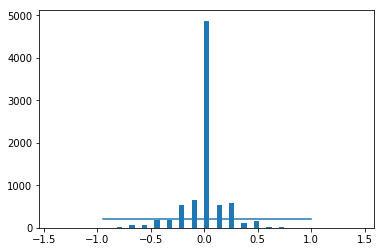

In [8]:
## Visualize data
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = bins[:-1] + bins[1:] * 0.5  # center the bins to 0

## Plot
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

### Preprocessing required
# 1.- Balance dataset

Total data: 8033
Removed: 6169
Remaining: 1864


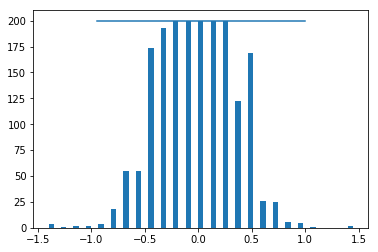

In [9]:
## Unskew data: for bins with >samples_per_bin, shuffle them and remove enough to have samples_per_bin 
print('Total data: {0}'.format(len(data)))

## Make list of indices to remove
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    steering_angle = data['steering'][i]
    if steering_angle >= bins[j] and steering_angle <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
  
## Remove from extras from list
data.drop(data.index[remove_list], inplace=True)
print('Removed: {0}'.format(len(remove_list)))
print('Remaining: {0}'.format(len(data)))

## Plot
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Training Samples: 1491
Çalid Samples: 373


Text(0.5, 1.0, 'Validation set')

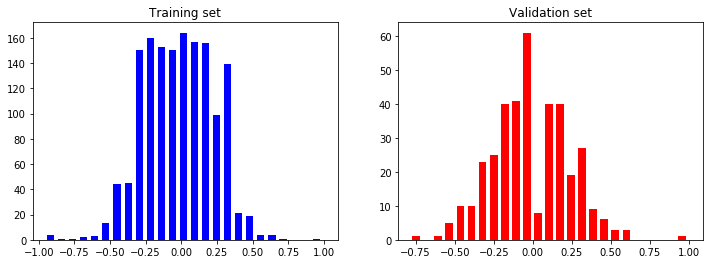

In [11]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

## Split data into training and validation
X_train_uri, X_valid_uri, Y_train, Y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=0)

## Check that data is valid
print("Training Samples: {}\nÇalid Samples: {}".format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(Y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(Y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')



## More preprocessing

In [21]:
from PIL import Image
from skimage.feature import *
s
# Resize pics:
Y_PIX = 80
X_PIX = 160
Y_CROP = 60
Y_CROP2 = 100
def img_preprocess(img_uri, my_visualize=False):
    image = npimg.imread(img_uri)
    img = cv2.normalize(image, image, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    # crop image:
    img = img[Y_CROP:Y_CROP2, :, :]
    # resize image:
    img = cv2.resize(img, (X_PIX, Y_PIX), interpolation=cv2.INTER_CUBIC)
    # grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # resize again
    img_gray = Image.fromarray(np.uint8(256 * img_gray))
    img_gray = img_gray.resize([int(0.5 * s) for s in img_gray.size], Image.ANTIALIAS)

    # hog features
    img_gray = hog(img_gray, pixels_per_cell=(8, 8), visualize=my_visualize)

    return img_gray


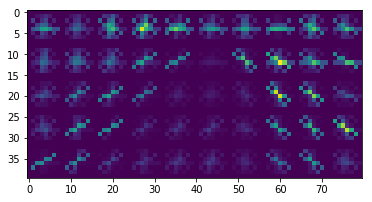

In [22]:
fd, img = img_preprocess(X_train_uri[0], my_visualize=True)
plt.imshow(img)


(1491, 1944)
(1944,)


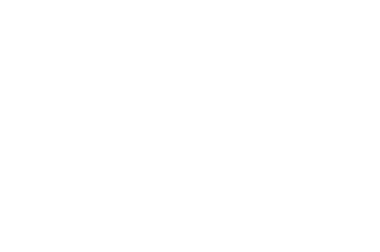

In [24]:
## Preprocess data (< 1min)
X_train = np.array(list(map(img_preprocess, X_train_uri)))
X_valid = np.array(list(map(img_preprocess, X_valid_uri)))
#plt.imshow(X_train[rn.randint(0, len(X_train)-1)])
plt.axis('off')
print(X_train.shape)
IMG_SIZE=X_train[0].shape
print(IMG_SIZE)

## Our dummy baseline model

In [25]:
import time
from sklearn.neighbors import KNeighborsRegressor
print("Training model...")
now = time.time()

regressor = KNeighborsRegressor(n_neighbors=5, weights='distance')

#Fit/train
regressor.fit(X_train, Y_train)

#Evaluate
print("Evaluating model...")
y_pred = regressor.predict(X_valid)
from sklearn import metrics

print('Mean Squared Error:', metrics.mean_squared_error(Y_valid, y_pred))

later = time.time()
print ("Elapsed time: {}s".format(later - now))


Training model...
Evaluating model...
Mean Squared Error: 0.015743716576466033
Elapsed time: 2.194493293762207s


In [26]:
PROJECT_PATH="/home/milhouse/projects/car-behavioral-cloning/"
PATH_TO_MODEL = '{}/models/model_meetup_knnr.pickle'.format(PROJECT_PATH)

import pickle
with open(PATH_TO_MODEL, 'wb') as handle:
    pickle.dump(regressor, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
!/home/milhouse/miniconda3/envs/car-behavioral-cloning-keras2/bin/python $PROJECT_PATH/my_drive.py $PROJECT_PATH/models/model_meetup_knnr.pickle $PROJECT_PATH/models/images_model_meetup & $PROJECT_PATH/beta_simulator_linux/beta_simulator.x86_64

Found path: /home/milhouse/projects/car-behavioral-cloning//beta_simulator_linux/beta_simulator.x86_64
Mono path[0] = '/home/milhouse/projects/car-behavioral-cloning//beta_simulator_linux/beta_simulator_Data/Managed'
Mono path[1] = '/home/milhouse/projects/car-behavioral-cloning//beta_simulator_linux/beta_simulator_Data/Mono'
Mono config path = '/home/milhouse/projects/car-behavioral-cloning//beta_simulator_linux/beta_simulator_Data/Mono/etc'
displaymanager : xrandr version warning. 1.5
client has 4 screens
displaymanager screen (0)(eDP1): 1366 x 768
Using libudev for joystick management


Importing game controller configs
Using TensorFlow backend.
OMP: Info #212: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #210: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-3
OMP: Info #156: KMP_AFFINITY: 4 available OS procs
OMP: Info #157: KMP_AFFINITY: Uniform topology
OMP: Info #179: KMP_AFFINITY: 1 packages x 2 core

In [28]:
!convert $PROJECT_PATH/models/images_model_meetup/*5.jpg $PROJECT_PATH/models/images_model_knnr.gif

<!--<img src="../models/images_model_keras_nvidia.gif" width="800">-->

<!--<img src="../models/images_model_knnr.gif" width="800">-->